# Problem 1

In this problem, a function `get_random_data` is defined that generates random data for logistic regression with two features, $x_1$ and $x_2$.

## Initial Setup

In [0]:
from mpl_toolkits import mplot3d

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Fix seed for consistent results
np.random.seed(42)

## Random Data Generation Function

In [0]:
def get_random_data(w, b, mu, sigma, m):
    num_train = (int)(m * 0.8)

    C = np.random.randint(0, 2, size=(m, 1))
    X_1 = np.random.uniform(size=(m, 1))
    N = np.random.normal(mu, sigma, size=(m, 1))

    X_2 = w * X_1 + b + (-1)**C * N

    data = np.concatenate((X_1, X_2), axis=1)
    labels = C

    return ((data[:num_train], labels[:num_train]), (data[num_train:], labels[num_train:]))


## Random Data Display Function

In [0]:
def display_random_data(data, labels, w, b):
    # Plot the data points
    colors = ['blue', 'red']
    plt.scatter(data[:,0].flatten(), data[:,1].flatten(), c=labels.flatten(), cmap=ListedColormap(colors))

    # Plot the true separating line
    xline = np.linspace(0, 1, 100)
    yline = w * xline + b
    plt.plot(xline, yline, '-k')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

## Test the Function

Two example cases are tested below. The first example gives a good, clear separation of the two groups. The second example, however, contains a large amount of overlap. The first example is used in later sections to train the models.

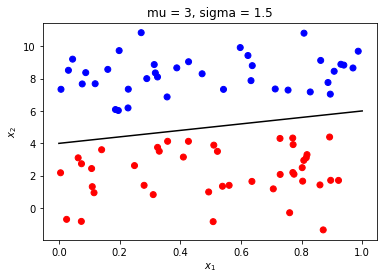

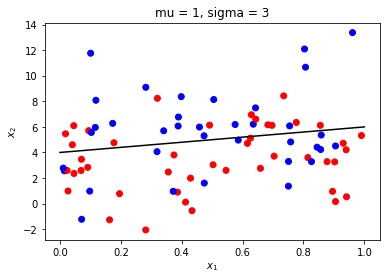

In [1001]:
w = 2
b = 4
mu = 3
sigma = 1.5
m = 100

(train_data, train_labels), (test_data, test_labels) = get_random_data(w, b, mu, sigma, m)
display_random_data(train_data, train_labels, w, b)
plt.title('mu = 3, sigma = 1.5')
plt.show()
plt.close()

mu = 1
sigma = 3

(train_data, train_labels), (test_data, test_labels) = get_random_data(w, b, mu, sigma, m)
display_random_data(train_data, train_labels, w, b)
plt.title('mu = 1, sigma = 3')
plt.show()
plt.close()

# Problem 2

In this problem, Keras is used to perform logistic regression on data sets generated from the function in Problem 1.

## Initial Setup

In [0]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf

# Fix seed for consistent results
np.random.seed(42)
tf.random.set_seed(42)

# Set parameters
w = 2
b = 4
mu = 3
sigma = 1.5
m = 1000

# Gather train and test data
(train_data, train_labels), (test_data, test_labels) = get_random_data(w, b, mu, sigma, m)


## Build the Model

A single dense layer is used to create the model. No more is needed, as the model is only making a simple linear prediction. The model maps the two input features to a single output, a probability on the range $[0, 1)$.

In [0]:
learning_rate = 0.01

model = tf.keras.models.Sequential()

dense_layer = tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(2, ))
model.add(dense_layer)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

## Perform Training

In [1004]:
epochs = 20
batch_size = 16

model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels))


Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 562us/sample - loss: 0.4413 - accuracy: 0.7975 - val_loss: 0.3850 - val_accuracy: 0.8550
Epoch 2/20
800/800 [==============================] - 0s 125us/sample - loss: 0.3427 - accuracy: 0.8963 - val_loss: 0.3071 - val_accuracy: 0.9350
Epoch 3/20
800/800 [==============================] - 0s 125us/sample - loss: 0.2757 - accuracy: 0.9375 - val_loss: 0.2541 - val_accuracy: 0.9500
Epoch 4/20
800/800 [==============================] - 0s 117us/sample - loss: 0.2263 - accuracy: 0.9538 - val_loss: 0.2138 - val_accuracy: 0.9500
Epoch 5/20
800/800 [==============================] - 0s 123us/sample - loss: 0.1899 - accuracy: 0.9650 - val_loss: 0.1843 - val_accuracy: 0.9600
Epoch 6/20
800/800 [==============================] - 0s 129us/sample - loss: 0.1651 - accuracy: 0.9688 - val_loss: 0.1639 - val_accuracy: 0.9650
Epoch 7/20
800/800 [==============================] - 0s 137us/sample - loss: 

## Analyze Results

To first analyze the results, I extracted the weights from the dense layer and created a function that maps combinations of $x_1$ and $x_2$ to the probability of classification. This is the function that the Keras model uses to make predictions.

$\huge p = \frac{1}{1+e^{-(w_1x_1 + w_2x_2 + b)}}$

 Using this function, I created a heatmap of the space covering the data points. The graph shows the test points (classified by blue and red), the true line (in black), and the heatmap (blue to red, matching the classification). This heatmap shows a clear line separating the two categories of data points.

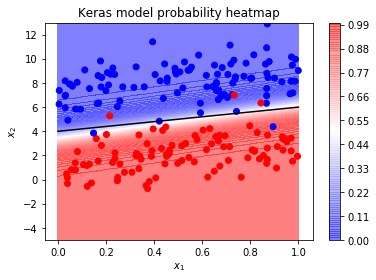

In [1005]:
def f(X_1, X_2, w, b):
    # Apply weights and bias
    z = w[0] * X_1 + w[1] * X_2 + b

    # Perform sigmoid activation function
    return 1.0 / (1.0 + np.exp(np.negative(z)))

# Define the heatmap region
X_1_range = np.linspace(0, 1)
X_2_range = np.linspace(-5, 13)
X_1, X_2 = np.meshgrid(X_1_range, X_2_range)

# Extract the layer's weights and bias
weights, bias = dense_layer.get_weights()

# Determine the probability function over the heatmap region
p_1 = f(X_1, X_2, weights, bias)

display_random_data(test_data, test_labels, w, b)

plt.contourf(X_1, X_2, p_1, 100, cmap='bwr', alpha=0.5, zorder=-1)
plt.colorbar()
plt.title('Keras model probability heatmap')
plt.show()


Now that this line has been established, I perform some math to extract the equation of this line. To do this, I set the formula from before to be equal to $\frac{1}{2}$ and solve for $x_2$

$\huge \frac{1}{1+e^{-(w_1x_1 + w_2x_2 + b)}} = \frac{1}{2}$

$\huge 1+e^{-(w_1x_1 + w_2x_2 + b)} = 2$

$\huge e^{-(w_1x_1 + w_2x_2 + b)} = 1$

$\huge w_1x_1 + w_2x_2 + b = 0$

$\huge x_2 = -\frac{w_1x_1 + b}{w_2}$

Using this equation, I create a new function that will display the trained line. The figure below shows the test points with the true line (in black) and the trained line (in magenta).

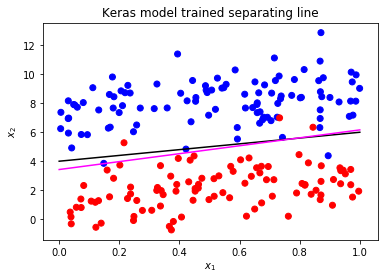

In [1006]:
display_random_data(test_data, test_labels, w, b)

xline = np.linspace(0, 1, 100)
yline = -((weights[0] * xline + bias)/weights[1])
plt.plot(xline, yline, color='magenta')
plt.title('Keras model trained separating line')
plt.show()


# Problem 3

In this problem, a logistic regression using stochastic gradient descent is implemented from scratch using NumPy.

## Initial Setup

In [0]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf

# Fix seed for consistent results
np.random.seed(42)
tf.random.set_seed(42)

# Set parameters
w = 2
b = 4
mu = 3
sigma = 1.5
m = 1000

# Gather train and test data
(train_data, train_labels), (test_data, test_labels) = get_random_data(w, b, mu, sigma, m)

## Define Functions Used by the Model

In [0]:
# Perform the sigmoid activation function on an input `z`
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(np.negative(z)))

# Process the input `X_b` according to the weights `W_b`
def process_input(X_b, W_b):
    # Apply weights and bias
    z = W_b.T.dot(X_b)

    # Perform sigmoid activation function
    return sigmoid(z)

# Make a prediction based on the result `a`
def predict(a):
    return 0 if a < 0.5 else 1

# Calcualte the binary cross-entropy loss for the prediction `a` and true label `label`
def binary_crossentropy(a, label):
    return -label*np.log(a) - (1 - label)*np.log(1 - a)

# Calculate the gradient of the binary cross-entropy loss for the prediction `a`, true label `label`, and input `X_b`
def loss_gradient(a, label, X_b):
    return (a - label) * X_b

# Perform a test of the model using the test data and labels, with weights `W_b`
def test_model(test_data, test_labels, W_b):
    correct_predictions = 0
    total_loss = 0

    for i_data in range(len(test_data)):
        # Process the input
        X_b = np.concatenate(([1], test_data[i_data]))
        a = process_input(X_b, W_b)

        # Make a prediction
        p = predict(a)
        if p == test_labels[i_data]:
            correct_predictions += 1
        
        # Determine loss
        total_loss += binary_crossentropy(a, test_labels[i_data])

    # Return a summary
    return (total_loss[0] / len(test_data), correct_predictions / len(test_data))


## Define the Model

A simple implementation of logistic regression, using only stochastic gradient descent.

In [0]:
def logistic_regression(train_data, train_labels, test_data, test_labels, epochs, learing_rate):
    # Randomize the initial weights
    W_b = np.random.random_sample((3, ))

    for epoch in range(epochs):
        # Only perform stochastic gradient descent
        for i_data in range(len(train_data)):
            # Process the input
            X_b = np.concatenate(([1], train_data[i_data]))
            a = process_input(X_b, W_b)

            # Determine the gradient of the loss
            Lg_b = loss_gradient(a, train_labels[i_data], X_b)

            # Apply the gradient to the weights
            W_b -= Lg_b * learning_rate
        
        # Analyze the loss and accuracy for each epoch
        loss, accuracy = test_model(test_data, test_labels, W_b)
        print(f'Epoch {epoch+1}/{epochs} - val_loss: {loss} - val_accuracy: {accuracy}')
    
    # Return the trained weights
    return W_b

## Run the Model

In [1010]:
epochs = 10
learning_rate = 0.01

W_b = logistic_regression(train_data, train_labels, test_data, test_labels, epochs, learning_rate)


Epoch 1/10 - val_loss: 0.2852680517706631 - val_accuracy: 0.91
Epoch 2/10 - val_loss: 0.21490160669396283 - val_accuracy: 0.94
Epoch 3/10 - val_loss: 0.17917091160280488 - val_accuracy: 0.96
Epoch 4/10 - val_loss: 0.15762120145374078 - val_accuracy: 0.96
Epoch 5/10 - val_loss: 0.14321953921728175 - val_accuracy: 0.97
Epoch 6/10 - val_loss: 0.13292257130692947 - val_accuracy: 0.97
Epoch 7/10 - val_loss: 0.1252011842969439 - val_accuracy: 0.975
Epoch 8/10 - val_loss: 0.11920285429900232 - val_accuracy: 0.975
Epoch 9/10 - val_loss: 0.11441447294496017 - val_accuracy: 0.98
Epoch 10/10 - val_loss: 0.11050855719863474 - val_accuracy: 0.98


## Analyze Results

As with Problem 2, the returned weights are used to generate a heatmap over the region.

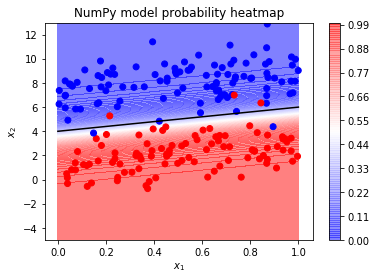

In [1011]:
# Define the heatmap region
X_1_range = np.linspace(0, 1)
X_2_range = np.linspace(-5, 13)
X_1, X_2 = np.meshgrid(X_1_range, X_2_range)

# Use function `f` from Problem 2
p_1 = f(X_1, X_2, [W_b[1], W_b[2]], W_b[0])

display_random_data(test_data, test_labels, w, b)

plt.contourf(X_1, X_2, p_1, 100, cmap='bwr', alpha=0.5, zorder=-1)
plt.colorbar()
plt.title('NumPy model probability heatmap')
plt.show()


An equation for the trained line is calculated and displayed, as in Problem 2. The true line is black, and the trained line is magenta.

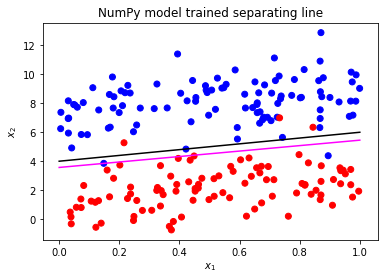

In [1012]:
display_random_data(test_data, test_labels, w, b)

xline = np.linspace(0, 1, 100)
yline = -((W_b[1] * xline + W_b[0])/W_b[2])
plt.plot(xline, yline, color='magenta')
plt.title('NumPy model trained separating line')
plt.show()


# References

P. Wocjan, "Gradients of logistic regression with squared error and binary cross-entropy loss functions," Feb. 2019